This notebook uses point estimates of the water table elevation (from standing water level and SNMR data) and explores option for interpolating the dataset based on terrain features. This requires a python environment with geopandas

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import os

In [18]:
# Open the interpolated points

infile = r"C:\Users\PCUser\Desktop\EK_data\Interp\KeepWaterTable\results\Keep_water_table_run3_culled.csv"

df = pd.read_csv(infile)

df['geometry'] = [Point(x,y) for x, y in df[['Easting', 'Northing']].values]

In [19]:
# Open the geomrophorphology polygon

infile = r"C:\Users\PCUser\Desktop\EK_data\vector\Keep_geomorphology\Geomorph_polygons7.2.shp"

gdf = gpd.read_file(infile)

In [20]:
# Get a code for the different gemorphology units

units = gdf['Name'].unique()

codes = {}

for i in range(len(units)):
    codes[units[i]] = i

codes['Unknown'] = -999

In [21]:

# Find which unit each of these units the points fall into

df['unit'] = -999

for index, row in df.iterrows():
    pt = row['geometry']
    try:
        poly_name = gdf[gdf.contains(pt)]['Name'].values[0]
        df.at[index,'unit'] = codes[poly_name]
    except IndexError:
        pass

In [22]:
colours = {-999:'grey', 0:'k', 1:'b', 2:'g', 3: 'r', 4:'c', 5:'m', 6:'y', 7:'w', 8:'pink', 9:'purple'}

df['colours'] = [colours[x] for x in df['unit'].values]

In [23]:
labels = []

for item in df['unit'].values:
    for key in codes:
        if codes[key] == item:
            labels.append(key)
df['label'] = labels

In [24]:
# Now run a linear regression on the bedrock values

df_br = df[df['label'] == 'Bedrock']

In [25]:
df

,Unnamed: 0,id,Easting,Northing,water_table_depth,source,link,lid100m_elevation_mAHD,water_table_elevation,geometry,unit,colours,label
0,1,RN029663,509738.0000,8297777.000,8.635000,borehole_measurement,NaN,14.855350,6.220350,POINT (509738 8297777),3,r,Alluvial plain
1,3,RN034821,514784.0000,8313635.000,7.450000,borehole_measurement,NaN,11.379500,3.929500,POINT (514784 8313635),0,k,Bedrock
2,5,RN029660,500047.8840,8295266.378,11.290000,borehole_measurement,NaN,19.127075,7.837075,POINT (500047.884 8295266.378),3,r,Alluvial plain
3,7,RN029665,512860.0000,8302461.000,7.975000,borehole_measurement,NaN,11.907226,3.932226,POINT (512860 8302461),3,r,Alluvial plain
4,9,RN029653,514021.0000,8301501.000,8.825000,borehole_measurement,NaN,12.885203,4.060203,POINT (514021 8301501),3,r,Alluvial plain
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,415,OK18_70,499206.4563,8286306.341,10.387130,SNMR_modelled,C:\Users\PCUser\Desktop\EK_data\Interp\KeepWat...,19.376511,8.989381,POINT (499206.4563 8286306.341),3,r,Alluvial plain
134,416,OK18_75,522306.2338,8301356.083,4.940802,SNMR_modelled,C:\Users\PCUser\Desktop\EK_data\Interp\KeepWat...,11.431900,6.491098,POINT (522306.2338 8301356.083),2,g,Alluvial and colluvial fans
135,417,OK18_76,500099.6412,8295239.253,9.078946,SNMR_modelled,C:\Users\PCUser\Desktop\EK_data\Interp\KeepWat...,19.066715,9.987769,POINT (500099.6412 8295239.253),3,r,Alluvial plain
136,418,OK18_78,500110.0260,8293822.738,11.815302,SNMR_modelled,C:\Users\PCUser\Desktop\EK_data\Interp\KeepWat...,19.963759,8.148457,POINT (500110.026 8293822.738),3,r,Alluvial plain


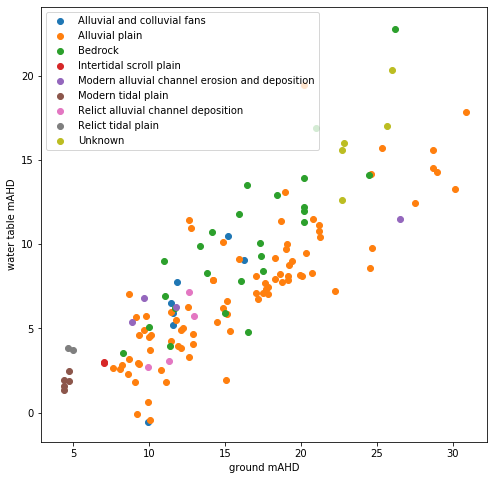

In [27]:
# Create a scatter plot of ground elevation vs water table elevation

fig, ax = plt.subplots(1,1,figsize=(8,8))


for color, group in df.groupby(['label']):
    ax.scatter(group['lid100m_elevation_mAHD'], group['water_table_elevation'], label=color)


ax.set_xlabel('ground mAHD')
ax.set_ylabel('water table mAHD')
plt.legend()

plt.show()

In [28]:
from scipy import stats

# Now run a linear regression on the bedrock values

df_subset = df[df['label'] == 'Bedrock']

x = df_subset['lid100m_elevation_mAHD'].values
y = df_subset['water_table_elevation'].values

br_slope, br_intercept, br_r_value, br_p_value, br_std_err = stats.linregress(x,y)

print("Slope is ", br_slope)
print("Intercetp is", br_intercept)
print("R-value is ", br_r_value**2)

Slope is  0.8115791178987888
Intercetp is -3.189570434762329
R-value is  0.6919230320473287


In [29]:
from scipy import stats

# Now run a linear regression on the bedrock values

df_subset = df[df['label'] == 'Alluvial plain']

x = df_subset['lid100m_elevation_mAHD'].values
y = df_subset['water_table_elevation'].values

ap_slope, ap_intercept, ap_r_value, ap_p_value, ap_std_err = stats.linregress(x,y)

print("Slope is ", ap_slope)
print("Intercetp is", ap_intercept)
print("R-value is ", ap_r_value**2)

Slope is  0.5743310809582683
Intercetp is -1.9201046297280389
R-value is  0.6945564134660025


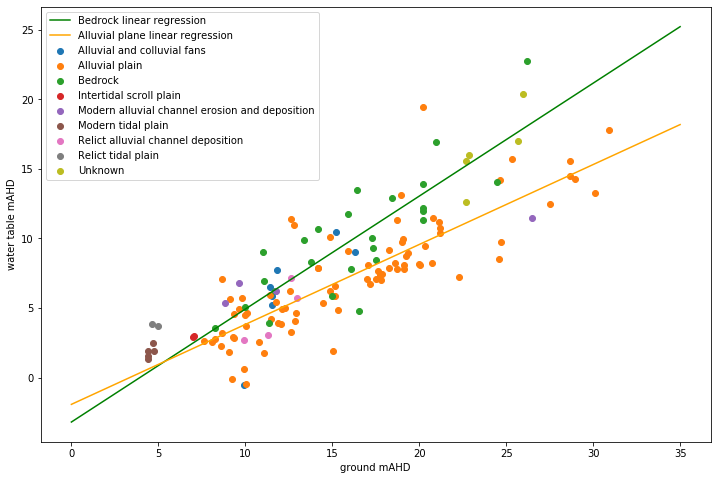

In [30]:
# Create a scatter plot of ground elevation vs water table elevation

fig, ax = plt.subplots(1,1,figsize=(12,8))

for color, group in df.groupby(['label']):
    ax.scatter(group['lid100m_elevation_mAHD'], group['water_table_elevation'], label=color)

# plot linea regression line

x = np.array([0,35])
y = br_slope*x + br_intercept

ax.plot(x,y, label = 'Bedrock linear regression', c = 'g')

y = ap_slope*x + ap_intercept

ax.plot(x,y, label = 'Alluvial plane linear regression', c= 'orange')

ax.set_xlabel('ground mAHD')
ax.set_ylabel('water table mAHD')
plt.legend()
plt.savefig(r"C:\Users\PCUser\Desktop\EK_data\Interp\KeepWaterTable\water_table_ground_elev_scatter_geomorph.png",
           dpi=300)
plt.show()

In [31]:
# Now we add some dummy points to the graph

new_xy = [[525088.7238,8307850.6],
          [508001.016,8289606.44],
          [508918.240,8292393.39],
          [506096.0122,8298408.263],
          [500733.7792,8292675.613]]
